# Backtest

In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta

In [2]:
from technicals import TechnicalAnalysis
import data.marketdata.alpaca as api

In [3]:
tickers = ['FB','AAPL','AMZN','NFLX','GOOG']
api_key_path = '../resources/api_keys.env'

In [4]:
ohlcv = api.ohlcv(tickers=tickers, api_key_path=api_key_path)

Testing Apaca Trade API key by data type:
ALPACA_API_KEY: <class 'str'>
ALPACA_SECRET_KEY: <class 'str'>


In [5]:
technicals = TechnicalAnalysis(ohlcv)

Open price data for AAPL


<AxesSubplot:xlabel='time'>

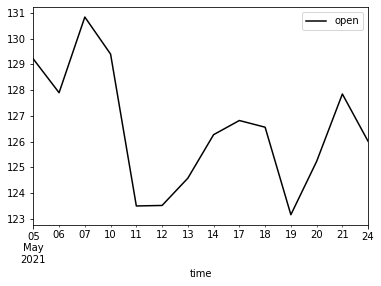

In [6]:
print(f"Open price data for {technicals.tickers()[0]}")
technicals._open(ticker=technicals.tickers()[0]).tail(14).plot(color='black')

### *Backtesting Williams %R*

In [42]:
def wr_backtest(ticker : str,
                wr_rules : pd.DataFrame,
                seed_cash : int or float,
                wr_range : int = 14,
                start_date : str = '2020-01-01',
                end_date : str = datetime.now().strftime('%Y-%m-%d'),
                debug : bool = False):
    
    '''
    Returns open price for ticker
        
        Parameters
        ----------
        ticker : str
            ticker to be processed
        start_date : str
            string with date in following format YYYY-MM-DD; default = '2020-01-01'
        end_date : str
            string with date in following format YYYY-MM-DD; default = today's date {datetime.now.strftime('%Y-%m-%d')}
        wr_bounds : pd.DataFrame
            rules for backtest, keys:
                'cond' : str 
                    equals : =
                    less : <
                    greater : >
                'val' : int or float
                    value for conditional 'elg'
                'act' : int
                    1 : long or close short
                    0 : hold
                    -1 : short or close long

        Returns
        -------
        df : DataFrame
            position values in $USD
    '''
    
    # get stock data and clean up df
    ohlcv = api.ohlcv(tickers=[ticker],
                      api_key_path=api_key_path,
                      start_date=start_date,
                      end_date=end_date)
    
    technicals = TechnicalAnalysis(ohlcv)
    data = technicals._close(ticker=ticker)
    data['wr'] = technicals.williams_range(ticker=ticker, days=wr_range)[wr_range:]
    data = data.dropna().reset_index()
    
    
    # instantiate stock and cash columns, seed columns
    data['pos'] = bool()
    data['stock_value'] = int()
    data['shares'] = int()
    data['cash'] = int()
    data['cash'].iloc[0] = seed_cash
    data['pos'].iloc[0] = False
            
    # iterate over close df
    for i in range(1,len(data.index)-1):
        lastday = data.iloc[i-1]
        today = data.iloc[i]
        pos = data.iloc[i-1]['pos']
        
        if debug:
            print(today.time)
        
        # long case
        if today['wr'] > wr_rules['long'] and lastday['wr'] <= wr_rules['long'] and pos == False:
            # handle stock
            shares = int(lastday['cash'] / today['close'])
            data.at[i, 'shares'] = shares
            
            stock_value = shares * today['close']
            data.at[i, 'stock_value'] = stock_value
            
            # handle cash
            cash = lastday['cash'] - stock_value
            data.at[i, 'cash'] = cash
            
            # handle position bool
            data.at[i, 'pos'] = True
            
            if debug:
                print(f"Open Long : shares - {shares}, stock_value - {stock_value}, cash - {cash}, close = {today['close']}, wr = {today['wr']}, pos {True}")
        
        
        # close long case
        elif today['wr'] < wr_rules['short'] and lastday['wr'] >= wr_rules['short'] and pos == True:
            # handle cash
            cash = lastday['cash'] + (lastday['shares'] * today['close'])
            data.at[i, 'cash'] = cash
            
            # handle stock
            shares = 0
            data.at[i, 'shares'] = shares
            
            stock_value = 0
            data.at[i, 'stock_value'] = stock_value
            
            # handle position bool
            data.at[i, 'pos'] = False
            
            if debug:
                print(f"Close Long : shares - {shares}, stock_value - {stock_value}, cash - {cash}, close = {today['close']}, wr = {today['wr']}, pos {True}")

        # hold case        
        else:
            # handle stock
            shares = lastday['shares']
            data.at[i, 'shares'] = shares
            
            stock_value = shares * today['close']
            data.at[i, 'stock_value'] = stock_value
            
            # handle cash
            cash = lastday['cash']
            data.at[i, 'cash'] = cash
            
            # handle position bool
            data.at[i, 'pos'] = lastday['pos']
            
            if debug:
                print(f"Hold : shares - {shares}, stock_value - {stock_value}, cash - {cash}, close = {today['close']}, wr = {today['wr']}, pos {True}")
           
    data = data.iloc[:-1,:]
    return data

In [63]:
# set backtest bounds logic
wr_rules = {'long' : -80,
             'short' : -20}

# set cash position and tracker
seed_cash = 1000000.0

data = wr_backtest(ticker = 'SYK',
            start_date = '2018-01-01',
            end_date = '2021-05-01',
                wr_rules = wr_rules,
                seed_cash = seed_cash,
                  wr_range=30)

Testing Apaca Trade API key by data type:
ALPACA_API_KEY: <class 'str'>
ALPACA_SECRET_KEY: <class 'str'>


C:\Users\illya\anaconda3\envs\trade_ai\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [64]:
init_hold_shares = data.iloc[0]['cash']/data.iloc[0]['close']

data['trade_portfolio'] = data['cash'] + data['stock_value']
data['hold_portfolio'] = init_hold_shares * data['close']
data = data.set_index('time')

In [65]:
data.head()

,close,wr,pos,stock_value,shares,cash,trade_portfolio,hold_portfolio
time,,,,,,,,
2018-02-14 00:00:00-05:00,156.24,-59.310345,False,0,0,1000000,1000000,1.000000e+06
2018-02-15 00:00:00-05:00,158.59,-49.181034,False,0,0,1000000,1000000,1.015041e+06
2018-02-16 00:00:00-05:00,159.84,-43.793103,False,0,0,1000000,1000000,1.023041e+06
2018-02-20 00:00:00-05:00,158.74,-48.534483,False,0,0,1000000,1000000,1.016001e+06
2018-02-21 00:00:00-05:00,157.95,-51.939655,False,0,0,1000000,1000000,1.010945e+06


In [66]:
data.tail()

,close,wr,pos,stock_value,shares,cash,trade_portfolio,hold_portfolio
time,,,,,,,,
2021-04-23 00:00:00-04:00,267.09,-2.363184,True,2367485,8864,225,2367710,1.709485e+06
2021-04-26 00:00:00-04:00,265.19,-7.089552,True,2350644,8864,225,2350869,1.697325e+06
2021-04-27 00:00:00-04:00,264.97,-7.636816,True,2348694,8864,225,2348919,1.695917e+06
2021-04-28 00:00:00-04:00,259.53,-21.169154,False,0,0,2300698,2300698,1.661098e+06
2021-04-29 00:00:00-04:00,263.52,-11.243781,False,0,0,2300698,2300698,1.686636e+06


<AxesSubplot:xlabel='time'>

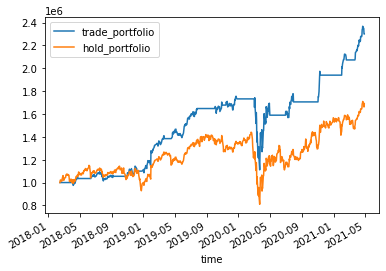

In [67]:
data[['trade_portfolio','hold_portfolio']].plot()